In [1]:
import quandl
quandl.ApiConfig.api_key = ''

In [2]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [3]:
tickers = ['SPY','VWO','IJR',
           'TLT',
           'HYG','TIP','GLD','USO']
factors = ['S&P 500','Emerging Markets','Small Cap',
           'Treasury Bonds',
           'High Yield','TIPS','Gold','Oil']

fund_df = quandl.get_table('SHARADAR/SFP', ticker=tickers, paginate=True)
fund_df.sort_values(by='date', ascending=True, inplace=True)

In [4]:
master = fund_df[fund_df['ticker']=='SPY'][['date','close']].copy(deep=True)
master.set_index('date', inplace=True)
master.rename({'close': factors[0]}, axis=1, inplace=True)

div = fund_df[fund_df['ticker']=='SPY'][['date','dividends']].copy(deep=True)
div.set_index('date', inplace=True)
div.rename({'dividends': factors[0]}, axis=1, inplace=True)

for i, ticker in enumerate(tickers[1:]):
    merge_df = fund_df[fund_df['ticker']==ticker][['date','close']].set_index('date')
    master = master.merge(merge_df, how='left', left_index=True, right_index=True)
    master.rename({'close': factors[i+1]}, axis=1, inplace=True)
    
    merge_df = fund_df[fund_df['ticker']==ticker][['date','dividends']].set_index('date')
    div = div.merge(merge_df, how='left', left_index=True, right_index=True)
    div.rename({'dividends': factors[i+1]}, axis=1, inplace=True)
    
master.dropna(inplace=True)

final = master/master.shift(1)-1 + div/master
factor_returns = final

In [5]:
# Optimization inputs
factor_moments = pd.DataFrame(np.mean(factor_returns, axis=0), columns=['Return'])
factor_moments['Vol'] = np.diag(factor_returns.cov())**0.5*(252**0.5)
vol = factor_moments['Vol']
cov =  factor_returns.cov()

world_weights = [45, 10, 3, 18, 6, 3, 1, 1]
world_weights = (np.array(world_weights)/sum(world_weights)).reshape(-1,1)

In [6]:
expected_returns = np.array([[ 0.080],
                             [ 0.092],
                             [ 0.092],
                             [-0.017],
                             [ 0.034],
                             [ 0.001],
                             [ 0.010],
                             [ 0.079]])

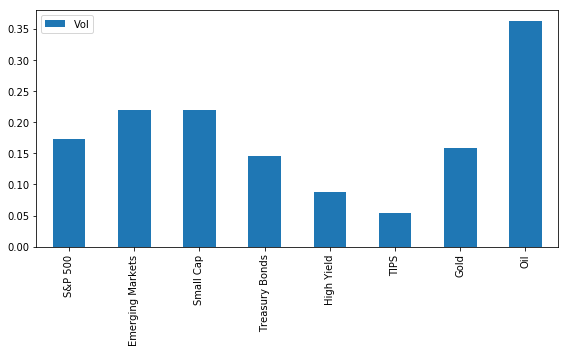

In [7]:
factor_moments[['Vol']].plot(kind='bar', figsize=(8,5));
plt.tight_layout()
plt.savefig('asset_risk')

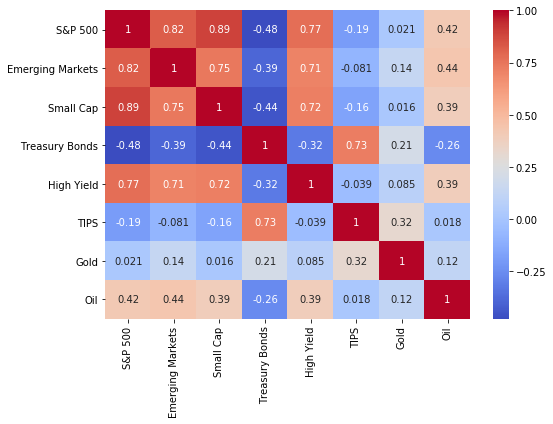

In [8]:
plt.subplots(figsize=(8,6))
sns.heatmap(final.corr(), annot=True, cmap='coolwarm')
plt.tight_layout()
plt.savefig('correlation')

In [9]:
# Mean Variance Optimization with Optimizer
from scipy.optimize import minimize, Bounds, LinearConstraint

# Function to optimize
def ret_risk(W, exp_ret, cov):
    return -((W.T@exp_ret) / (W.T@cov@W)**0.5)

# Optimization bounds and constraints
W = np.ones((factor_moments.shape[0],1))*(1.0/factor_moments.shape[0])

# Function that runs optimizer
def optimize(func, W, exp_ret, cov, target_return):
    opt_bounds = Bounds(0, 1)
    opt_constraints = ({'type': 'eq',
                        'fun': lambda W: 1.0 - np.sum(W)},
                       {'type': 'eq',
                        'fun': lambda W: target_return - W.T@exp_ret})
    optimal_weights = minimize(func, W, 
                               args=(exp_ret, cov),
                               method='SLSQP',
                               bounds=opt_bounds,
                               constraints=opt_constraints)
    return optimal_weights['x']

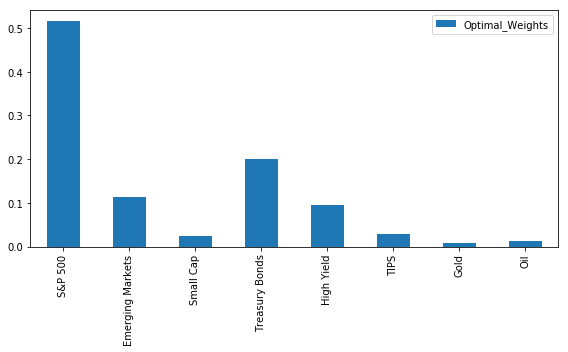

In [10]:
x = optimize(ret_risk, W, expected_returns, cov, 
             target_return=0.055)
opt_W = pd.DataFrame(x, index=factor_moments.index, columns=['Optimal_Weights'])
opt_W.plot(kind='bar', figsize=(8,5));
plt.tight_layout()
plt.savefig('optimal_weights')